## Imports

In [ ]:
import sys
import json
import tifffile
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

from scipy.ndimage import binary_erosion, binary_dilation

In [ ]:
sys.path.append(r"C:\\Users\\97254\\Desktop\\git\\MS2")

In [ ]:
from cell_tracking import get_masks_paths
from src.utils.gif_utils import create_gif_from_figures
from src.utils.image_utils import enhance_cell_image_contrast

## Functions

In [ ]:
# Visualization utilities
def cluster_mask_overlay(
    masks: np.ndarray,
    clustered_cells_df: pd.DataFrame,
    tracklets: dict,
    timepoint: int,
    rng_seed: int = 0,
    base_image: np.ndarray | None = None,
    overlay_alpha: float = 0.6,
    background_color=(0, 0, 0),
    out_dtype=np.uint8,
    cluster_name_map: dict = None,
    fixed_colors: dict = None
):
    """
    Return an RGB image made by overlaying each cluster's cells over a base image.

    If base_image is None, the overlay is drawn on a solid background_color.

    Parameters
    ----------
    masks : np.ndarray
        2D (H,W) or 3D (Z,H,W) labeled mask(s).
    clustered_cells_df : pd.DataFrame
        Columns: ['cell', 'cluster'].
    tracklets : dict
        tracklets[track_id][timepoint] -> label in masks for that cell at timepoint.
    timepoint : int
        Time index.
    rng_seed : int
        Seed for random colors (used for clusters not in fixed_colors).
    base_image : np.ndarray | None
        Grayscale (H,W) or RGB (H,W,3) image to blend underneath the cluster colors.
    overlay_alpha : float
        Opacity of the cluster color in [0,1]. 0=transparent, 1=opaque.
    background_color : tuple
        Used only if base_image is None.
    out_dtype : numpy dtype
        Output dtype (default uint8).
    cluster_name_map : dict | None
        Map cluster id -> human-readable name.

    Fixed colors:
        0 -> dark gray
        1 -> white
        2 -> yellow
        3 -> red

    Returns
    -------
    img : (H,W,3) array
        RGB image with clusters blended over the base image.
    cluster_colors : dict {cluster_id: (r,g,b)}
    cluster_labels : dict {cluster_id: str}
    """
    if cluster_name_map is None:
        cluster_name_map = {
            0: "non active cells",
            1: "shortly active",
            2: "highly active",
            3: "moderate active",
            4: "weakly active",
        }
    if fixed_colors is None:
        fixed_colors = {
            0: (64, 64, 64),      # dark gray
            1: (255, 0, 0),       # red
            2: (255, 255, 255),   # white
            3: (255, 255, 0),     # yellow
            4: (255, 165, 0),     # orange
        }

    if masks.ndim == 2:
        vol = masks[None, ...]
    elif masks.ndim == 3:
        vol = masks
    else:
        raise ValueError("masks must be 2D or 3D")

    _, H, W = vol.shape

    # Prepare base RGB image (either from base_image or solid background)
    def to_uint8_rgb(img: np.ndarray) -> np.ndarray:
        # Validate spatial size
        if img.ndim == 2:
            if img.shape != (H, W):
                raise ValueError(f"base_image shape {img.shape} must match (H,W)=({H},{W})")
            rgb = np.stack([img, img, img], axis=-1)
        elif img.ndim == 3 and img.shape[-1] == 3:
            if img.shape[:2] != (H, W):
                raise ValueError(f"base_image shape {img.shape[:2]} must match (H,W)=({H},{W})")
            rgb = img
        else:
            raise ValueError("base_image must be 2D (H,W) or 3D (H,W,3)")

        if rgb.dtype == np.uint8:
            return rgb.copy()

        if np.issubdtype(rgb.dtype, np.floating):
            mx = float(np.nanmax(rgb)) if np.isfinite(rgb).any() else 0.0
            if mx <= 1.0:
                rgb = (np.clip(rgb, 0.0, 1.0) * 255.0).astype(np.uint8)
            else:
                rgb = np.clip(rgb, 0.0, 255.0).astype(np.uint8)
            return rgb

        # e.g., uint16 or other integer types
        mx = float(rgb.max()) if rgb.size > 0 else 0.0
        if mx > 0:
            rgb = (rgb.astype(np.float32) * (255.0 / mx)).clip(0, 255).astype(np.uint8)
        else:
            rgb = np.zeros_like(rgb, dtype=np.uint8)
        return rgb

    if base_image is None:
        base_rgb = np.empty((H, W, 3), dtype=np.uint8)
        base_rgb[:] = np.array(background_color, dtype=np.uint8)
    else:
        base_rgb = to_uint8_rgb(base_image)

    # Clamp alpha
    overlay_alpha = float(np.clip(overlay_alpha, 0.0, 1.0))

    rng = np.random.default_rng(rng_seed)
    cluster_ids = clustered_cells_df['cluster'].unique()
    cluster_colors: dict[int, tuple[int, int, int]] = {}
    cluster_labels: dict[int, str] = {}

    # cell -> cluster map
    cell_to_cluster = {}
    for _, row in clustered_cells_df.iterrows():
        cell_name = str(row['cell'])
        if cell_name.startswith('cell_'):
            cell_name = cell_name[5:]
        cell_to_cluster[cell_name] = row['cluster']

    # collect labels in masks per cluster
    cluster_to_labels = {cid: [] for cid in cluster_ids}
    for track_id, track in tracklets.items():
        cid = cell_to_cluster.get(str(track_id))
        if cid is None:
            continue
        if timepoint >= len(track):
            continue
        lab = track[timepoint]
        if lab is None or lab == 0:
            continue
        cluster_to_labels[cid].append(lab)

    # Prepare overlay color buffer and a combined mask
    overlay_rgb = np.zeros((H, W, 3), dtype=np.uint8)
    any_mask = np.zeros((H, W), dtype=bool)

    # paint clusters into overlay_rgb
    for cid in cluster_ids:
        labels = list({l for l in cluster_to_labels[cid] if l != 0})
        if not labels:
            continue
        color = fixed_colors.get(cid, tuple(rng.integers(0, 256, size=3).tolist()))
        cluster_colors[cid] = color
        cluster_labels[cid] = cluster_name_map.get(cid, f"Cluster {cid}")
        mask_bool = np.isin(vol, labels).any(axis=0)  # (H, W)
        if np.any(mask_bool):
            overlay_rgb[mask_bool] = np.array(color, dtype=np.uint8)
            any_mask |= mask_bool

    # Blend overlay over base image
    img = base_rgb.astype(np.float32)
    if np.any(any_mask):
        m = any_mask
        img[m] = (1.0 - overlay_alpha) * img[m] + overlay_alpha * overlay_rgb[m].astype(np.float32)
    img = img.clip(0, 255).astype(out_dtype)

    return img, cluster_colors, cluster_labels



def build_cluster_contour_overlay(
    masks: np.ndarray,
    clustered_cells_df: pd.DataFrame,
    tracklets: dict,
    timepoint: int,
    rng_seed: int = 0,
    base_image: np.ndarray | None = None,
    contour_thickness: int = 1,
    overlay_alpha: float = 1.0,
    background_color=(0, 0, 0),
    out_dtype=np.uint8,
    cluster_name_map: dict = None,
    fixed_colors: dict = None
):
    """
    Draw colored contours (outlines) for each cluster over a base image.

    If base_image is None, contours are drawn over a solid background_color.

    Parameters
    ----------
    masks : np.ndarray
        2D (H,W) or 3D (Z,H,W) labeled mask(s).
    clustered_cells_df : pd.DataFrame
        Columns: ['cell', 'cluster'].
    tracklets : dict
        tracklets[track_id][timepoint] -> label in masks for that cell at timepoint.
    timepoint : int
        Time index.
    rng_seed : int
        Seed for random colors (used for clusters not in fixed_colors).
    base_image : np.ndarray | None
        Grayscale (H,W) or RGB (H,W,3) image to draw under the contours.
    contour_thickness : int
        Approximate thickness of the contour in pixels (>=1).
    overlay_alpha : float
        Alpha for contour color in [0,1]. 1.0 replaces the underlying pixel.
    background_color : tuple
        Used only if base_image is None.
    out_dtype : numpy dtype
        Output dtype (default uint8).
    cluster_name_map : dict | None
        Map cluster id -> human-readable name.

    Fixed colors:
        0 -> dark gray, 1 -> white, 2 -> yellow, 3 -> red

    Returns
    -------
    img : (H,W,3) array
        RGB image with cluster contours.
    cluster_colors : dict {cluster_id: (r,g,b)}
    cluster_labels : dict {cluster_id: str}
    """
    if cluster_name_map is None:
        cluster_name_map = {
            0: "non active cells",
            1: "highly active",
            2: "moderate active",
            3: "weakly active",
        }
    if fixed_colors is None:
        fixed_colors = {
            0: (64, 64, 64),      # dark gray
            1: (255, 255, 255),   # white
            2: (255, 255, 0),     # yellow
            3: (255, 0, 0),       # red
        }

    if masks.ndim == 2:
        vol = masks[None, ...]
    elif masks.ndim == 3:
        vol = masks
    else:
        raise ValueError("masks must be 2D or 3D")

    _, H, W = vol.shape

    # Prepare base RGB
    def to_uint8_rgb(img: np.ndarray) -> np.ndarray:
        if img.ndim == 2:
            if img.shape != (H, W):
                raise ValueError(f"base_image shape {img.shape} must match (H,W)=({H},{W})")
            rgb = np.stack([img, img, img], axis=-1)
        elif img.ndim == 3 and img.shape[-1] == 3:
            if img.shape[:2] != (H, W):
                raise ValueError(f"base_image shape {img.shape[:2]} must match (H,W)=({H},{W})")
            rgb = img
        else:
            raise ValueError("base_image must be 2D (H,W) or 3D (H,W,3)")

        if rgb.dtype == np.uint8:
            return rgb.copy()
        if np.issubdtype(rgb.dtype, np.floating):
            mx = float(np.nanmax(rgb)) if np.isfinite(rgb).any() else 0.0
            if mx <= 1.0:
                return (np.clip(rgb, 0.0, 1.0) * 255.0).astype(np.uint8)
            return np.clip(rgb, 0.0, 255.0).astype(np.uint8)
        mx = float(rgb.max()) if rgb.size > 0 else 0.0
        if mx > 0:
            return (rgb.astype(np.float32) * (255.0 / mx)).clip(0, 255).astype(np.uint8)
        return np.zeros_like(rgb, dtype=np.uint8)

    if base_image is None:
        base_rgb = np.empty((H, W, 3), dtype=np.uint8)
        base_rgb[:] = np.array(background_color, dtype=np.uint8)
    else:
        base_rgb = to_uint8_rgb(base_image)

    overlay_alpha = float(np.clip(overlay_alpha, 0.0, 1.0))
    contour_thickness = max(1, int(contour_thickness))

    rng = np.random.default_rng(rng_seed)
    cluster_ids = clustered_cells_df['cluster'].unique()
    cluster_colors: dict[int, tuple[int, int, int]] = {}
    cluster_labels: dict[int, str] = {}

    # cell -> cluster
    cell_to_cluster = {}
    for _, row in clustered_cells_df.iterrows():
        cell_name = str(row['cell'])
        if cell_name.startswith('cell_'):
            cell_name = cell_name[5:]
        cell_to_cluster[cell_name] = row['cluster']

    # labels per cluster
    cluster_to_labels = {cid: [] for cid in cluster_ids}
    for track_id, track in tracklets.items():
        cid = cell_to_cluster.get(str(track_id))
        if cid is None or timepoint >= len(track):
            continue
        lab = track[timepoint]
        if lab is None or lab == 0:
            continue
        cluster_to_labels[cid].append(lab)

    # Helpers to compute contours without external deps
    def shift_bool(m: np.ndarray, dy: int, dx: int) -> np.ndarray:
        out = np.zeros_like(m, dtype=bool)
        y0s = max(0, -dy); y0e = m.shape[0] - max(0, dy)
        x0s = max(0, -dx); x0e = m.shape[1] - max(0, dx)
        yds = max(0, dy); yde = yds + (y0e - y0s)
        xds = max(0, dx); xde = xds + (x0e - x0s)
        if y0e > y0s and x0e > x0s:
            out[yds:yde, xds:xde] = m[y0s:y0e, x0s:x0e]
        return out

    def contour_from_mask(m: np.ndarray, thickness: int) -> np.ndarray:
        # 4-neighborhood interior test
        up = shift_bool(m, -1, 0)
        down = shift_bool(m, 1, 0)
        left = shift_bool(m, 0, -1)
        right = shift_bool(m, 0, 1)
        interior = m & up & down & left & right
        boundary = m & (~interior)

        if thickness <= 1:
            return boundary

        # Thicken boundary by OR-ing shifted copies (no wrap-around)
        thick = boundary.copy()
        for r in range(1, thickness):
            for dy, dx in [(-r, 0), (r, 0), (0, -r), (0, r),
                           (-r, -r), (-r, r), (r, -r), (r, r)]:
                thick |= shift_bool(boundary, dy, dx)
        return thick

    # Start from base
    img = base_rgb.astype(np.float32)

    # Draw contours per cluster
    for cid in cluster_ids:
        labels = list({l for l in cluster_to_labels[cid] if l != 0})
        if not labels:
            continue
        color = fixed_colors.get(cid, tuple(rng.integers(0, 256, size=3).tolist()))
        cluster_colors[cid] = color
        cluster_labels[cid] = cluster_name_map.get(cid, f"Cluster {cid}")
        c = np.array(color, dtype=np.float32)
        for label in labels:
            cell_stack = (vol == label)
            proj = cell_stack.max(axis=0)  # 2D projection of this cell
            if not proj.any():
                continue
            eroded = binary_erosion(proj, iterations=1, border_value=0)
            outline = proj ^ eroded
            if contour_thickness > 1:
                outline = binary_dilation(outline, iterations=contour_thickness - 1)
            contour = outline
            if overlay_alpha >= 1.0:
                img[contour] = c
            else:
                img[contour] = (1.0 - overlay_alpha) * img[contour] + overlay_alpha * c
    img = img.clip(0, 255).astype(out_dtype)
    return img, cluster_colors, cluster_labels


In [ ]:
def show_clustered_heat_map(labels, cells_array, cell_names):
    order = np.argsort(labels)
    cells_sorted = cells_array[order]
    labels_sorted = labels[order]
    cell_names_sorted = [cell_names[i] for i in order]

    # Find boundaries between clusters for horizontal separator lines
    boundary_rows = np.where(np.diff(labels_sorted) != 0)[0] + 1
    unique_labels = np.unique(labels_sorted)

    # Color palette for clusters
    palette = sns.color_palette("tab10", n_colors=unique_labels.size)
    label_to_color = {lab: palette[i] for i, lab in enumerate(unique_labels)}
    row_colors = [label_to_color[l] for l in labels_sorted]

    # Plot heatmap with an auxiliary color bar for clusters
    fig = plt.figure(figsize=(20,20))
    gs = fig.add_gridspec(1, 2, width_ratios=[20, 0.6], wspace=0.05)

    ax_hm = fig.add_subplot(gs[0, 0])
    sns.heatmap(
        cells_sorted,
        cmap="viridis",
        ax=ax_hm,
        robust=True,
        # set to cell_names_sorted if you want all labels (may be long)
        yticklabels=False
    )

    # Add horizontal lines to separate clusters
    for br in boundary_rows:
        ax_hm.axhline(br, color='red', lw=2.0)

    ax_hm.set_title("Gene Expression Heatmap (rows grouped by cluster)")
    ax_hm.set_xlabel("Timepoint index")
    ax_hm.set_ylabel("Cells (sorted)")


    plt.tight_layout()
    plt.show()
    return pd.DataFrame({"cell": cell_names_sorted,"cluster": labels_sorted})

## Inputs

In [247]:
video_name = 'gRNA_4_26.02.25-st_14_A1_A4---'
tracklet_length = 1

In [231]:
csv_path = f'c:\\Users\\97254\\Desktop\\Resources\\Technion\\grad_school\\shechtman_lap\\projects\\MS2\\outputs\\{video_name}\\emitter_analysis\\gene_expression_results.csv'
tracklets_path = f'c:\\Users\\97254\\Desktop\\Resources\\Technion\\grad_school\\shechtman_lap\\projects\\MS2\\outputs\\{video_name}\\tracklets_matching_iou_v2.json'
masks_dir = f'c:\\Users\\97254\\Desktop\\Resources\\Technion\\grad_school\\shechtman_lap\\projects\\MS2\\outputs\\{video_name}\\masks'

In [233]:
df = pd.read_csv(csv_path)

In [234]:
df.head()

,timepoint,cell_0,cell_1,cell_2,cell_3,cell_4,cell_5,cell_6,cell_7,cell_8,...,cell_915,cell_920,cell_928,cell_929,cell_931,cell_932,cell_933,cell_934,cell_935,cell_942
0,0,73.0,0.0,0.0,81.0,0.0,0.0,272.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,72.0,0.0,0.0,181.0,0.0,0.0,225.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,69.0,0.0,0.0,90.0,0.0,0.0,154.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,26.0,0.0,0.0,0.0,0.0,0.0,225.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,53.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [235]:
with open(tracklets_path, 'r') as f:
        tracklets = json.load(f)

In [236]:
masks_paths = get_masks_paths(masks_dir)

## Gene Visualization

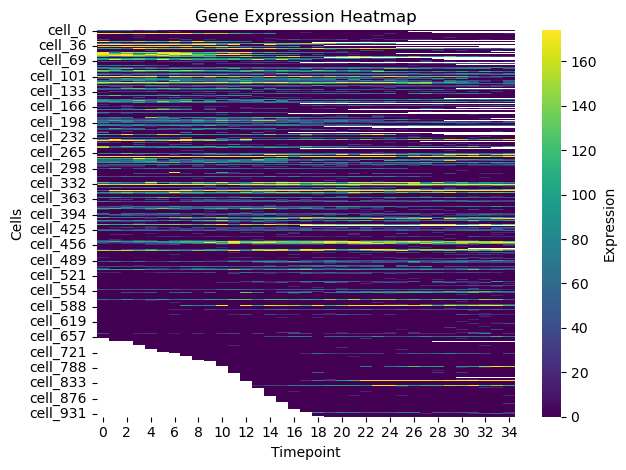

In [237]:
data = df.sort_values('timepoint').set_index('timepoint')

# Flip axes: rows=cells, columns=timepoints
plt.figure()
sns.heatmap(data.T, cmap="viridis", robust=True,
            cbar_kws={"label": "Expression"})
plt.title("Gene Expression Heatmap")
plt.xlabel("Timepoint")
plt.ylabel("Cells")
plt.tight_layout()
plt.show()

In [238]:
num = df.drop(columns=['timepoint'], errors='ignore').select_dtypes(
    include=np.number)
min_non_zero = num.where(num > 0).min()  # per-column min of values > 0
min_non_zero

cell_0      16.0
cell_1       6.0
cell_2      17.0
cell_3      18.0
cell_4      16.0
            ... 
cell_932     NaN
cell_933     NaN
cell_934     NaN
cell_935     NaN
cell_942     NaN
Length: 781, dtype: float64

In [239]:
np.nanmean(min_non_zero), np.nanmedian(min_non_zero)

(25.617753623188406, 18.0)

In [248]:
nan_counts = df.drop(columns=['timepoint'], errors='ignore').isna().sum()
cols_gt1_nan = nan_counts[nan_counts > tracklet_length].index.tolist()
cols_gt1_nan  # list of column names with >1 NaN
df_filtered = df.drop(columns=cols_gt1_nan)

In [249]:
len(df.columns)

782

In [250]:
len(df_filtered.columns)

564

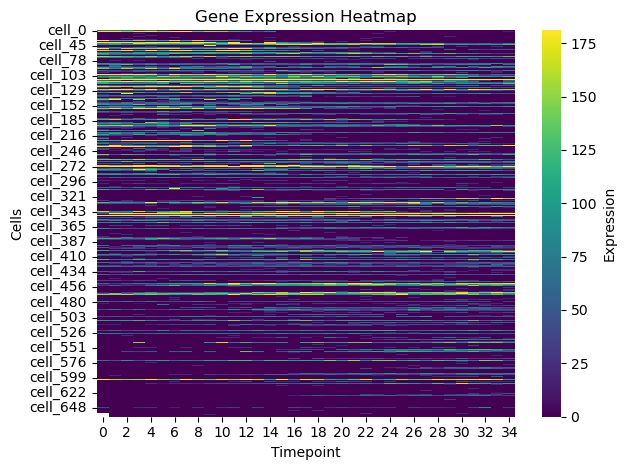

In [251]:
filtered_data = df_filtered.sort_values('timepoint').set_index('timepoint')

# Flip axes: rows=cells, columns=timepoints
plt.figure()
sns.heatmap(filtered_data.T, cmap="viridis", robust=True,
            cbar_kws={"label": "Expression"})
plt.title("Gene Expression Heatmap")
plt.xlabel("Timepoint")
plt.ylabel("Cells")
plt.tight_layout()
plt.show()

### Gene Clustering

In [252]:
df_filled = df_filtered.fillna(0.0)

In [253]:
cells_array = df_filled.drop(
    columns=['timepoint'], errors='ignore').to_numpy()[:-1, :].T

In [254]:
cell_names = df_filled.drop(
    columns=['timepoint'], errors='ignore').columns.tolist()
assert len(
    cell_names) == cells_array.shape[0], "Mismatch between cell names and cells_array rows"

In [255]:
def normalise_signals(cells_array, noise = 20):
    cells_array[cells_array < noise] = noise
    cells_array = cells_array - noise
    return (cells_array - np.min(cells_array)) / np.max(cells_array)

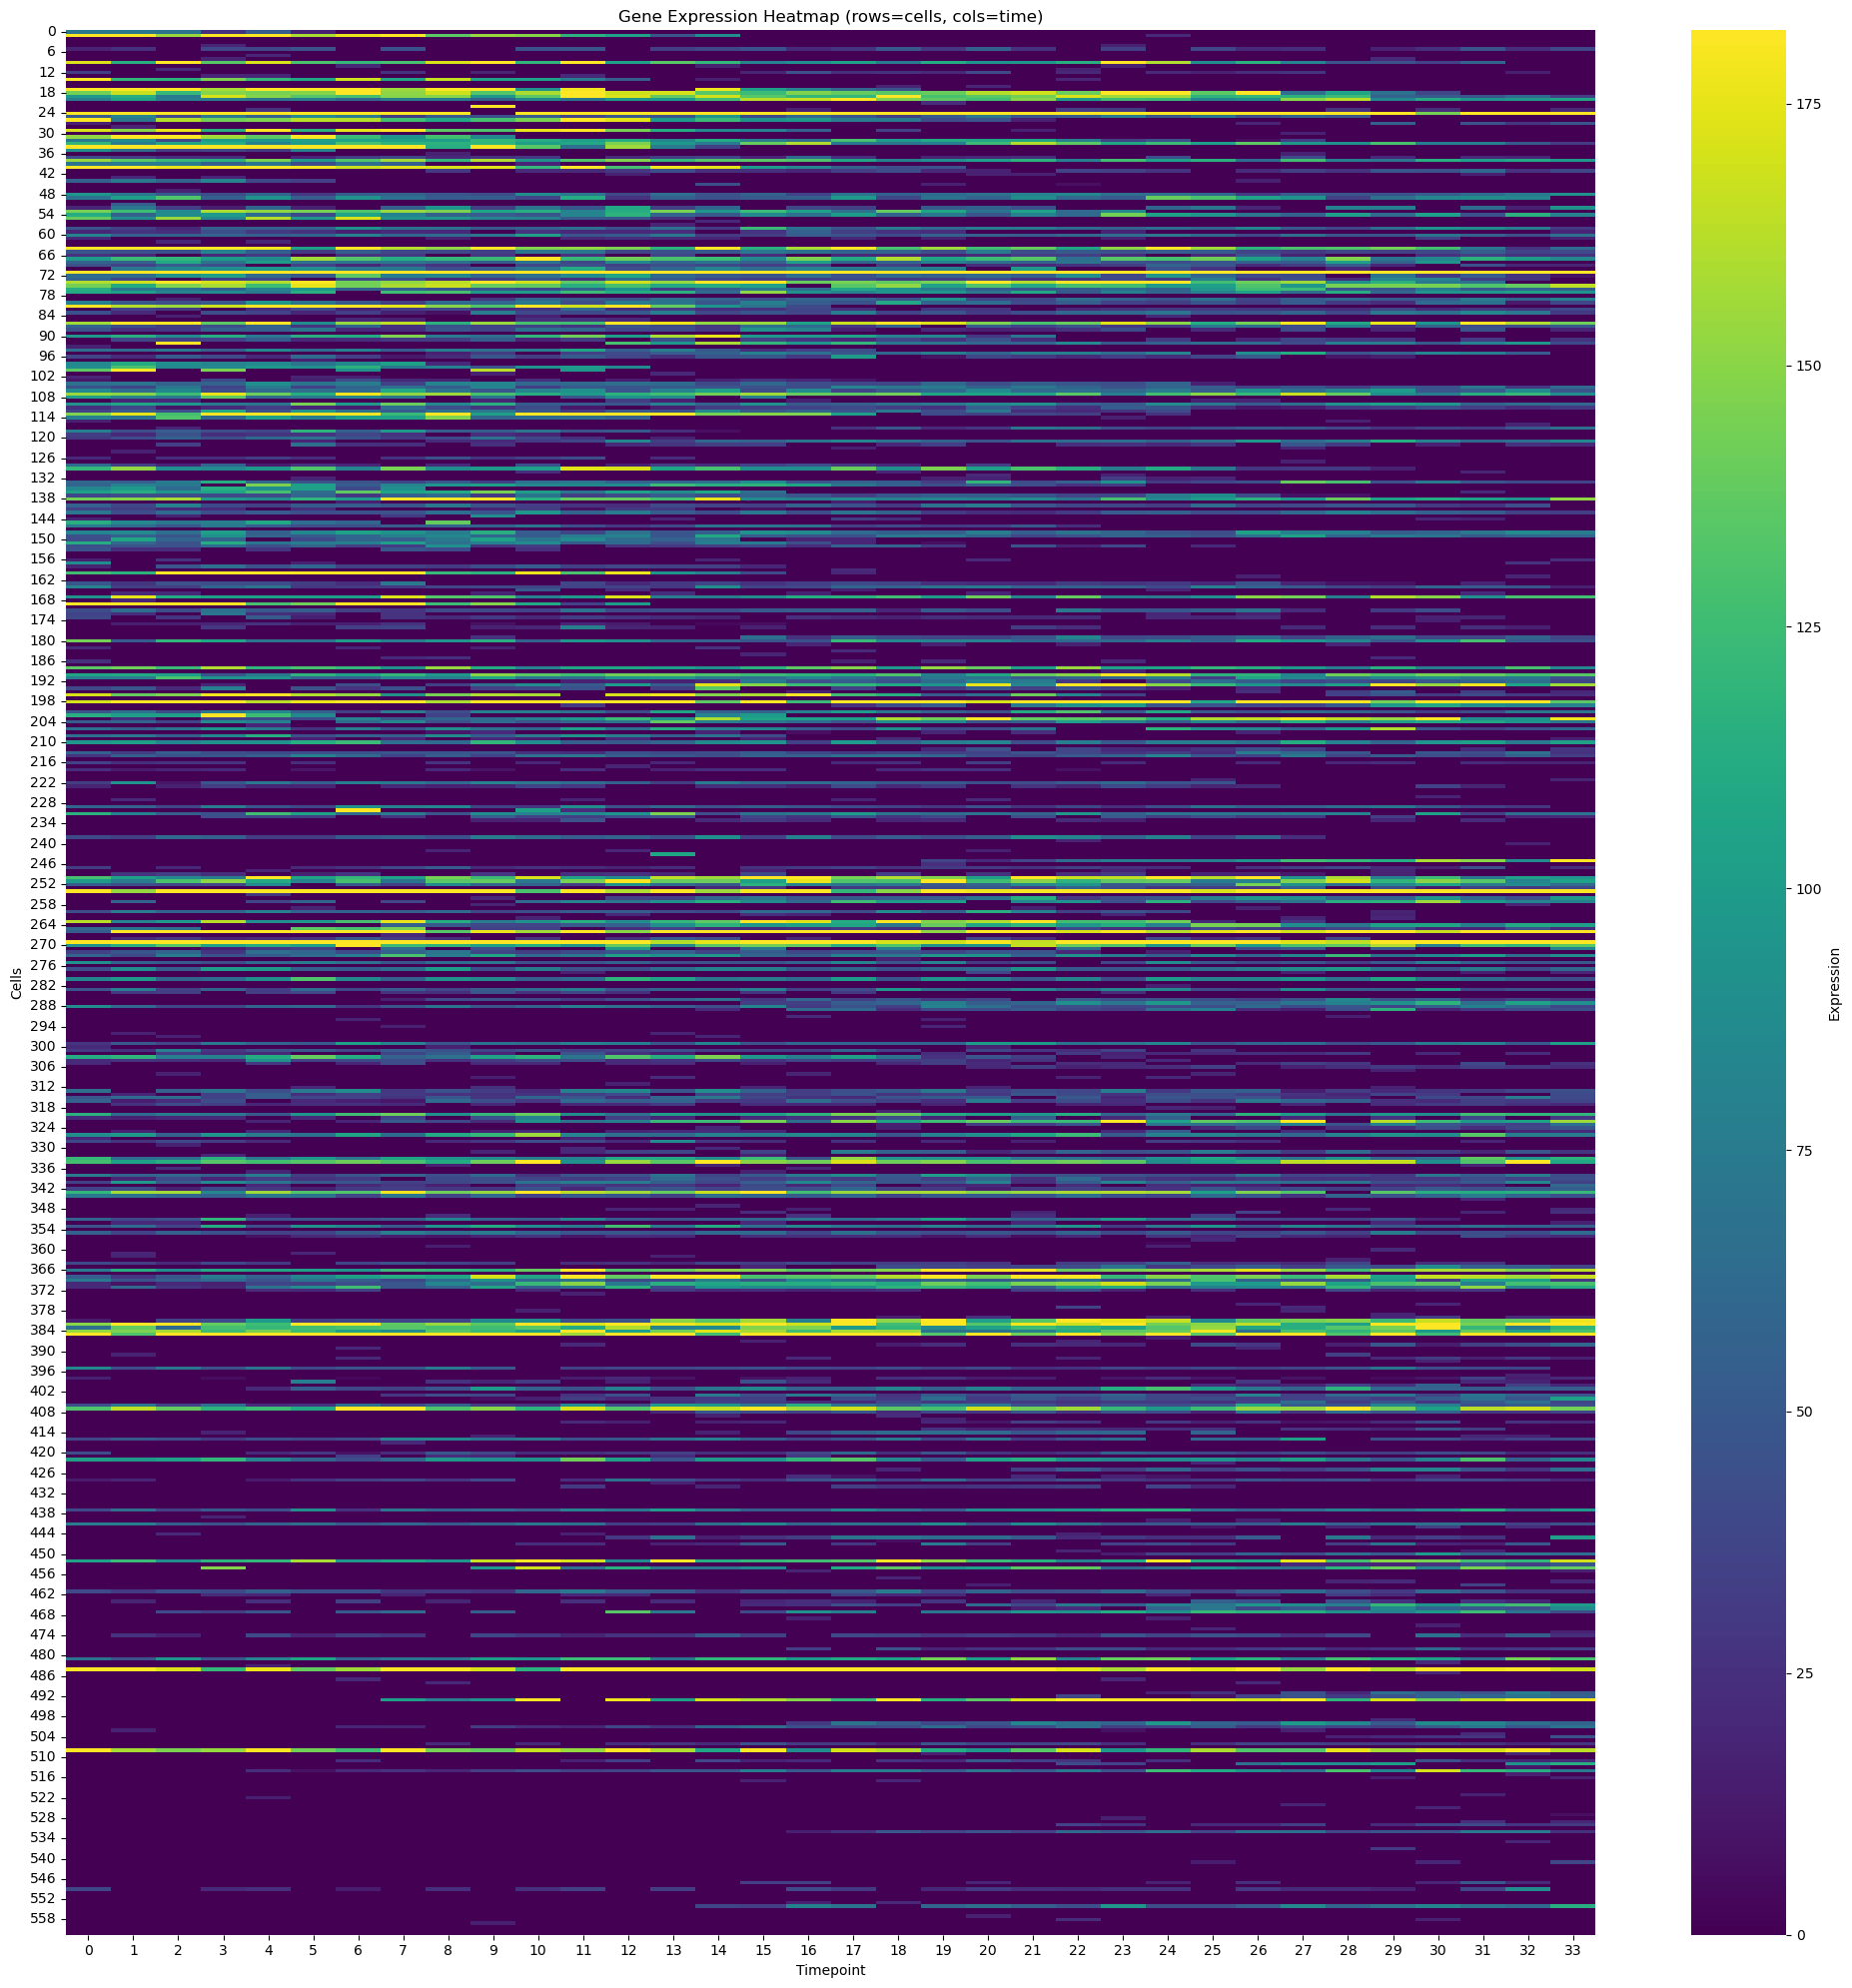

In [256]:
plt.figure(figsize=(20,20))
sns.heatmap(cells_array, cmap="viridis", robust=True,
            cbar_kws={"label": "Expression"})
plt.title("Gene Expression Heatmap (rows=cells, cols=time)")
plt.xlabel("Timepoint")
plt.ylabel("Cells")
plt.tight_layout()
plt.show()

In [257]:
normalized_array = normalise_signals(cells_array, 20)

#### PCA K means 

In [258]:
pca = PCA(n_components='mle', svd_solver='full')
Z = pca.fit_transform(normalized_array)
components = pca.components_
explained = pca.explained_variance_ratio_

In [259]:
Z.shape, components.shape, explained.shape

((563, 28), (28, 34), (28,))

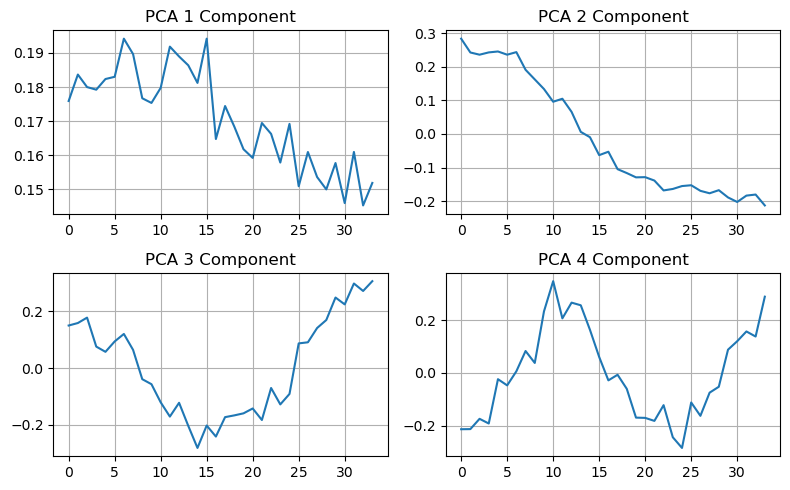

In [260]:
fig, ax = plt.subplots(2, 2, figsize=(8, 5))
ax[0, 0].plot(components[0], label=f'PCA1')
ax[0, 0].set_title("PCA 1 Component")
ax[0, 1].plot(components[1], label=f'PCA2')
ax[0, 1].set_title("PCA 2 Component")
ax[1, 0].plot(components[2], label=f'PCA3')
ax[1, 0].set_title("PCA 3 Component")
ax[1, 1].plot(components[3], label=f'PCA4')
ax[1, 1].set_title("PCA 4 Component")
ax[0, 0].grid(True)
ax[0, 1].grid(True)
ax[1, 0].grid(True)
ax[1, 1].grid(True)
plt.tight_layout()
plt.show()

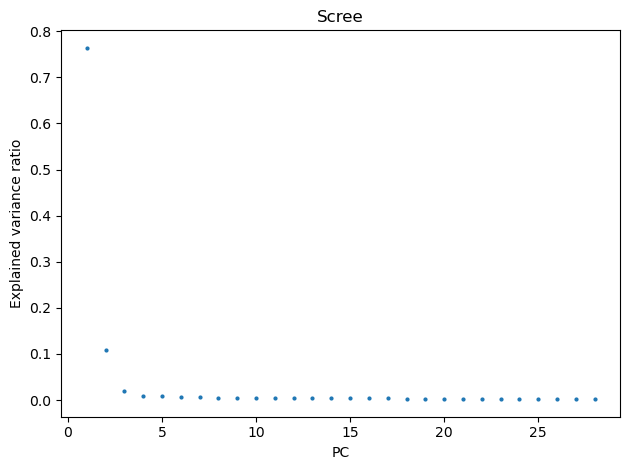

In [261]:
plt.scatter(np.arange(1, len(explained)+1), explained, marker='o', s=4)
plt.xlabel('PC')
plt.ylabel('Explained variance ratio')
plt.title('Scree')
plt.tight_layout()
plt.show()

In [262]:
labels = KMeans(n_clusters=5, random_state=0).fit_predict(Z[:, :6])

c:\Users\97254\anaconda3\envs\ms2_env\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


In [263]:
np.unique(labels)

array([0, 1, 2, 3, 4])

C:\Users\97254\AppData\Local\Temp\ipykernel_45624\752601277.py:39: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


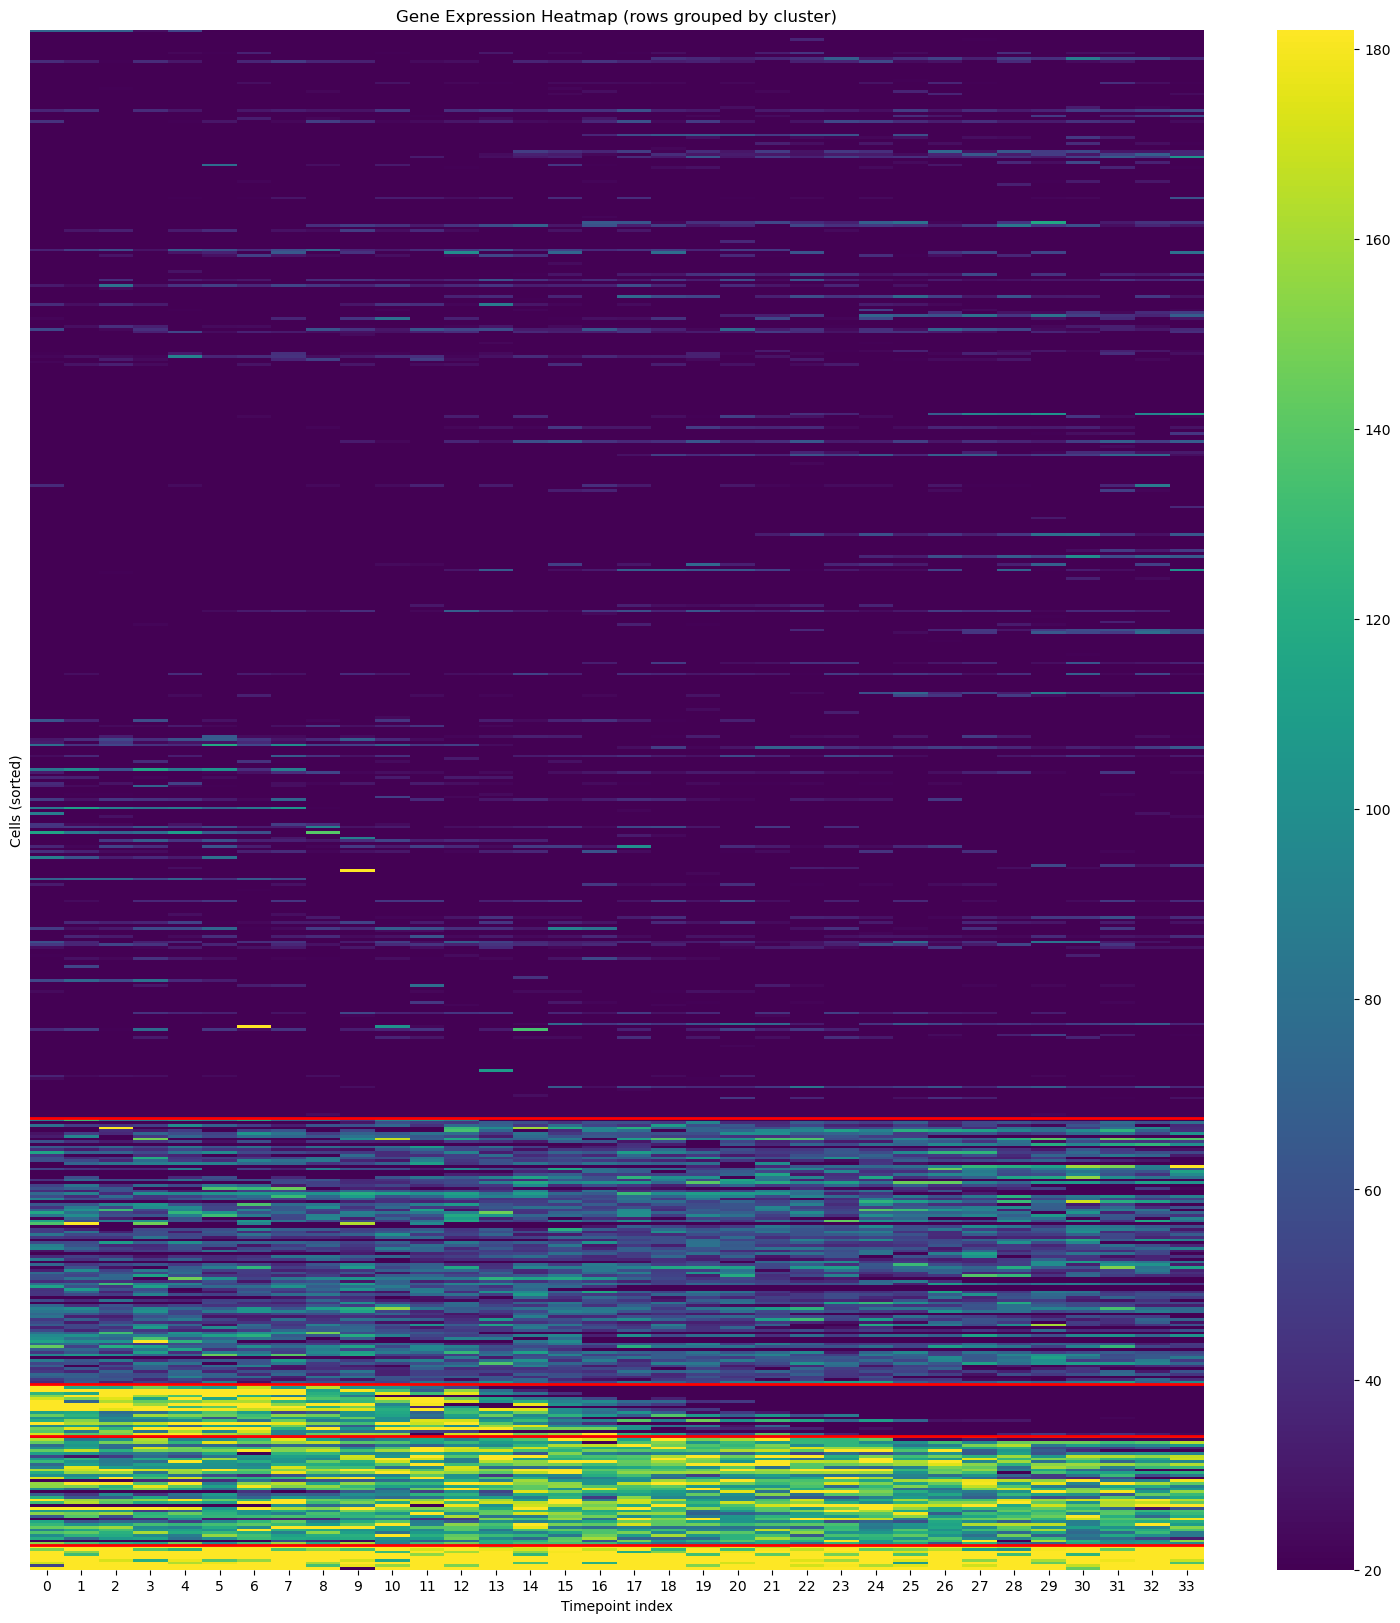

In [264]:
clustered_cells_df = show_clustered_heat_map(labels, cells_array, cell_names)

In [265]:
labels = labels + 1  # make labels 1-based
labels

array([1, 3, 1, 1, 1, 1, 1, 1, 1, 4, 1, 1, 1, 1, 3, 1, 1, 3, 4, 4, 4, 1,
       1, 1, 5, 2, 3, 1, 1, 3, 1, 3, 2, 4, 3, 1, 1, 1, 4, 1, 3, 1, 1, 1,
       1, 1, 1, 1, 2, 2, 1, 1, 2, 3, 2, 3, 1, 1, 2, 1, 2, 1, 1, 1, 4, 2,
       1, 4, 2, 1, 2, 5, 2, 1, 4, 4, 2, 4, 1, 2, 2, 3, 1, 2, 1, 1, 4, 2,
       1, 1, 3, 1, 2, 1, 2, 2, 1, 1, 1, 2, 2, 1, 1, 1, 2, 2, 2, 4, 2, 1,
       2, 1, 2, 3, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1,
       1, 2, 2, 1, 3, 2, 4, 1, 2, 1, 2, 1, 1, 1, 2, 1, 2, 2, 2, 2, 1, 1,
       1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 2, 1, 1, 4, 1, 3, 1, 2, 1, 1, 1, 1,
       1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 4, 1, 4, 2, 1, 4, 1, 1, 3, 1,
       5, 2, 1, 2, 2, 4, 2, 1, 2, 1, 2, 1, 2, 1, 1, 2, 2, 1, 1, 1, 1, 1,
       1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1,
       1, 1, 1, 2, 1, 1, 1, 1, 4, 4, 2, 1, 5, 1, 2, 2, 1, 1, 2, 1, 1, 4,
       2, 2, 5, 1, 1, 5, 4, 1, 1, 2, 1, 2, 1, 2, 1, 1, 2, 1, 1, 2, 1, 1,
       1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1,

In [266]:
pos = np.where(labels == 1)[0]
pos

array([  0,   2,   3,   4,   5,   6,   7,   8,  10,  11,  12,  13,  15,
        16,  21,  22,  23,  27,  28,  30,  35,  36,  37,  39,  41,  42,
        43,  44,  45,  46,  47,  50,  51,  56,  57,  59,  61,  62,  63,
        66,  69,  73,  78,  82,  84,  85,  88,  89,  91,  93,  96,  97,
        98, 101, 102, 103, 109, 111, 115, 116, 117, 118, 119, 120, 122,
       123, 124, 125, 126, 127, 128, 130, 131, 132, 135, 139, 141, 143,
       144, 145, 147, 152, 153, 154, 155, 156, 157, 158, 159, 161, 162,
       163, 165, 166, 168, 170, 172, 173, 174, 175, 176, 177, 178, 179,
       181, 182, 183, 184, 185, 186, 187, 189, 192, 194, 195, 197, 200,
       205, 207, 209, 211, 212, 215, 216, 217, 218, 219, 220, 221, 223,
       224, 225, 226, 227, 228, 230, 232, 233, 234, 235, 236, 237, 239,
       240, 241, 242, 243, 244, 246, 247, 248, 249, 253, 255, 258, 259,
       261, 262, 267, 268, 271, 272, 274, 276, 278, 279, 281, 282, 284,
       285, 286, 289, 290, 291, 292, 293, 294, 295, 296, 297, 29

In [267]:
labels_secondary = KMeans(n_clusters=2, random_state=0).fit_predict(Z[pos, :6])
labels_secondary

c:\Users\97254\anaconda3\envs\ms2_env\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1,
       0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0,

In [268]:
pos1 = np.where(labels_secondary == 1)[0]
change_label_pos = pos[pos1]

In [269]:
labels[change_label_pos] = 0  # Change to cluster 0

In [270]:
labels

array([1, 3, 1, 1, 1, 0, 1, 1, 1, 4, 1, 1, 1, 1, 3, 1, 1, 3, 4, 4, 4, 1,
       1, 1, 5, 2, 3, 1, 1, 3, 1, 3, 2, 4, 3, 1, 1, 1, 4, 0, 3, 0, 1, 1,
       1, 1, 1, 1, 2, 2, 1, 1, 2, 3, 2, 3, 1, 1, 2, 1, 2, 1, 1, 1, 4, 2,
       1, 4, 2, 0, 2, 5, 2, 0, 4, 4, 2, 4, 1, 2, 2, 3, 0, 2, 1, 1, 4, 2,
       0, 1, 3, 0, 2, 1, 2, 2, 0, 1, 0, 2, 2, 1, 1, 1, 2, 2, 2, 4, 2, 1,
       2, 0, 2, 3, 2, 1, 1, 0, 0, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1,
       1, 2, 2, 0, 3, 2, 4, 1, 2, 1, 2, 1, 1, 0, 2, 1, 2, 2, 2, 2, 0, 1,
       1, 1, 1, 1, 1, 1, 3, 1, 1, 0, 2, 1, 1, 4, 1, 3, 1, 2, 1, 1, 1, 1,
       1, 1, 1, 0, 2, 1, 1, 1, 1, 1, 1, 1, 4, 1, 4, 2, 0, 4, 0, 1, 3, 1,
       5, 2, 1, 2, 2, 4, 2, 1, 2, 1, 2, 1, 2, 1, 1, 2, 2, 1, 1, 1, 1, 1,
       1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 2, 0, 1, 1, 1, 1, 1, 2, 1, 1, 1,
       1, 1, 1, 2, 1, 0, 1, 1, 4, 4, 2, 0, 5, 1, 2, 2, 1, 1, 2, 1, 1, 4,
       2, 2, 5, 1, 1, 5, 4, 0, 0, 2, 1, 2, 1, 2, 1, 1, 2, 1, 1, 2, 1, 1,
       0, 2, 2, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1,

In [271]:
labels_swapped = np.where(labels == 0, 1,
                  np.where(labels == 1, 0, labels))

C:\Users\97254\AppData\Local\Temp\ipykernel_45624\752601277.py:39: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


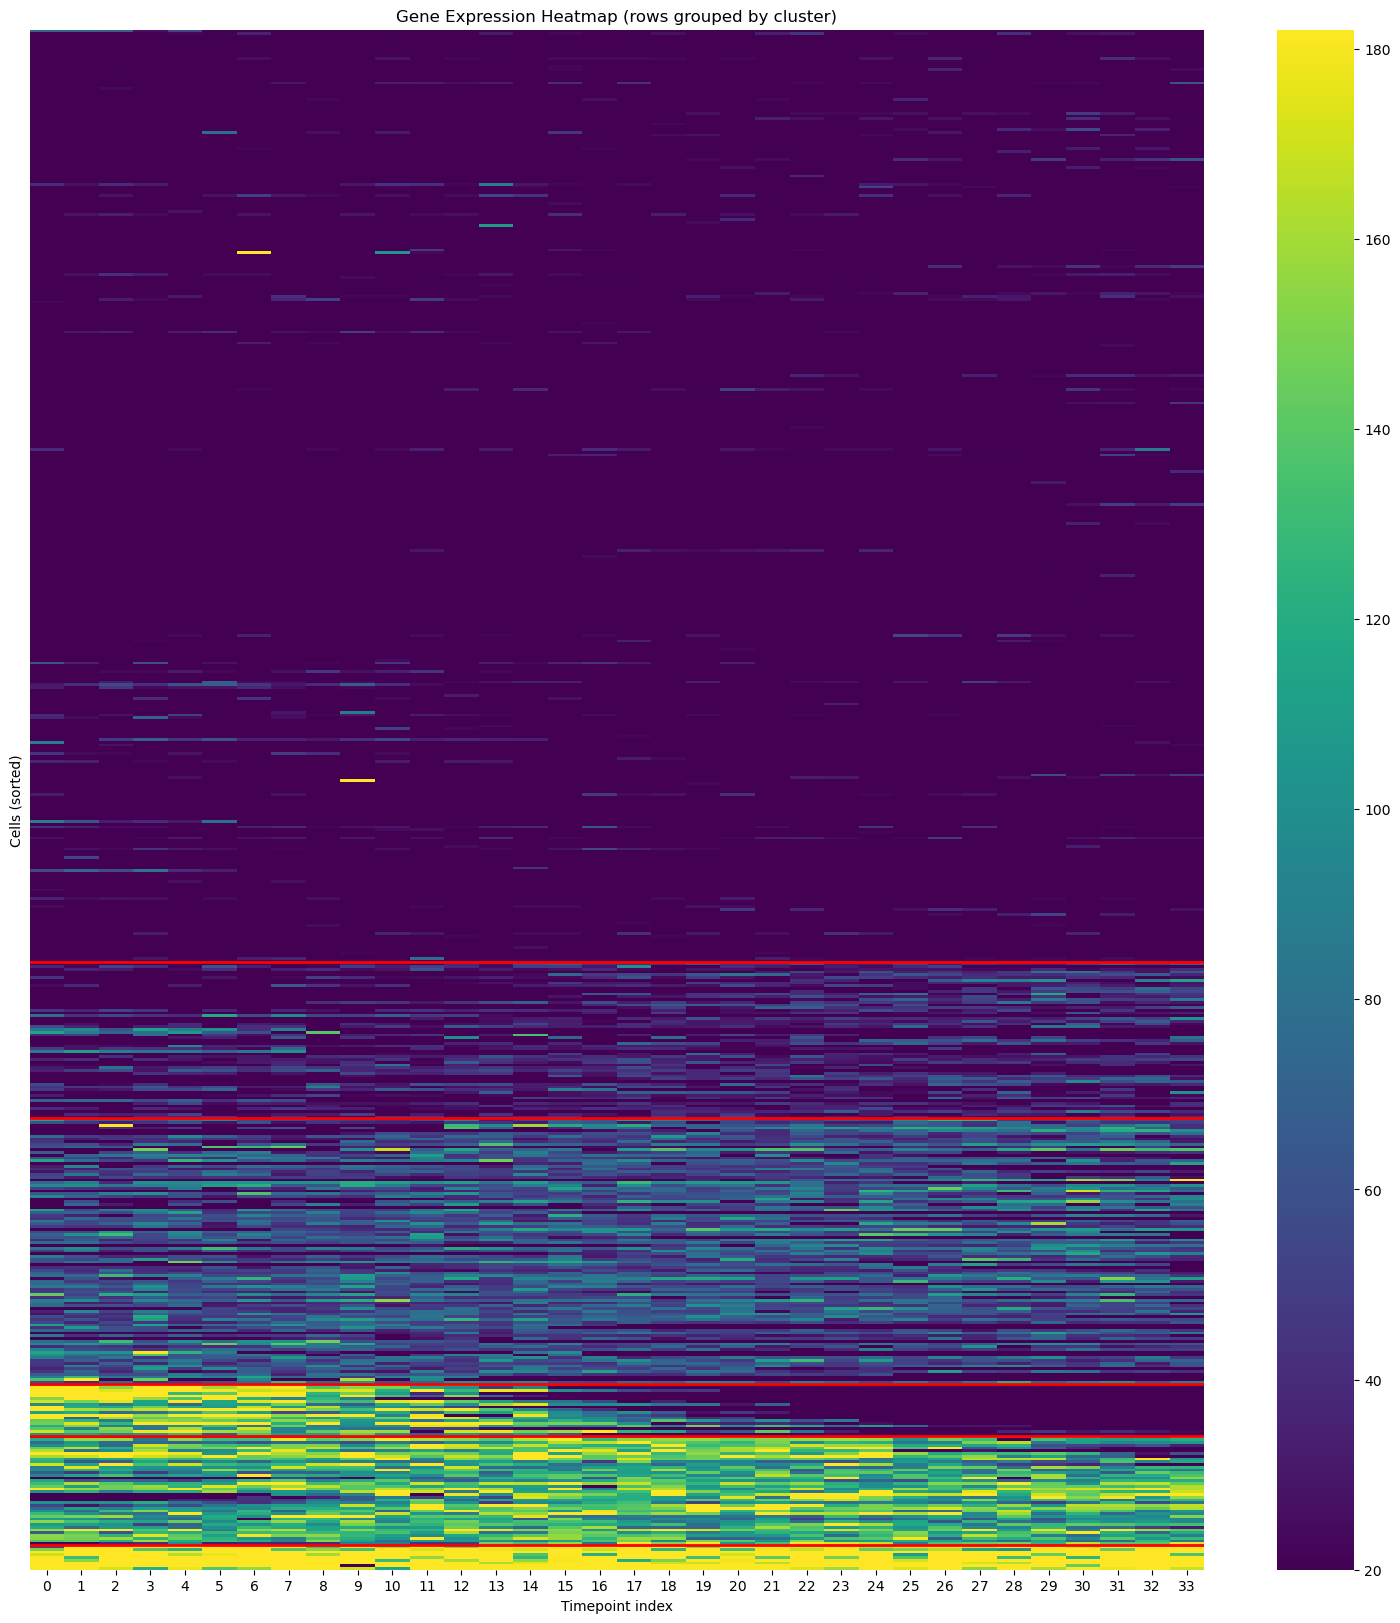

In [272]:
# ---- Heatmap sorted by KMeans cluster labels ----
# Row (cell) names in the same order used to build cells_array

clustered_cells_df = show_clustered_heat_map(labels_swapped, cells_array, cell_names)

In [273]:
cells_z_project_path = f'c:\\Users\\97254\\Desktop\\Resources\\Technion\\grad_school\\shechtman_lap\\projects\\MS2\\data\\czi_files\\{video_name}\\SUM_C2-{video_name}.tif'

In [274]:
cells_z_project =  tifffile.imread(cells_z_project_path)

In [277]:
ms2_channel_z_projection_path = f'c:\\Users\\97254\\Desktop\\Resources\\Technion\\grad_school\\shechtman_lap\\projects\\MS2\\data\\czi_files\\{video_name}\\SUM_C1-{video_name}.tif'

In [278]:
ms2_channel_z_projection = tifffile.imread(ms2_channel_z_projection_path)

In [203]:
ms2_channel_z_projection.shape

(80, 1024, 1024)

In [ ]:
figures = []
for timepoint in range(ms2_channel_z_projection.shape[0]):
    ms2_img = enhance_cell_image_contrast(ms2_channel_z_projection[timepoint])
    enhanced_img = enhance_cell_image_contrast(cells_z_project[timepoint])
    masks_t = np.load(masks_paths[timepoint])['masks']
    overlay_img, cluster_colors, cluster_labels = cluster_mask_overlay(
        masks=masks_t,
        clustered_cells_df=clustered_cells_df,
        tracklets=tracklets,
        timepoint=timepoint,
        rng_seed=42,
        base_image=None,
        overlay_alpha=0.6,
        background_color=(0, 0, 0),
        out_dtype=np.uint8,
        cluster_name_map={
            0: "non active cells",
            1: "short bursts",
            2: "highly active at the end",
            3: "highly active",
            4: "highly active at the beginning",
            5: "moderate active"
        },
        fixed_colors={
            0: (64,64,64),      # dark gray
            1: (128,0,128),       # purple
            2: (255, 255,0),   # yellow
            3: (255,255,255),       # white
            4: (255, 165, 0),     # orange
            5: (255,0,0),     # red
        })
    fig = plt.figure(figsize=(6,6))
    plt.imshow(overlay_img)
    plt.axis('off')
    plt.title(f"Cluster at timepoint {timepoint}")
    # Legend
    def _to_rgb01(c):
        c = np.asarray(c, dtype=float).ravel()
        if c.max() > 1.0:
            c = c / 255.0
        return tuple(np.clip(c, 0.0, 1.0))
    handles = [
        Patch(facecolor=_to_rgb01(c), edgecolor='black',
          label=f"{cluster_labels[cid]}")
    for cid, c in cluster_colors.items()]
    plt.legend(handles=handles, loc='upper right', fontsize=6)
    plt.tight_layout()
    figures.append(fig)
    plt.close(fig)
# Save as GIF
create_gif_from_figures(figures[:-1],f'mask_overlay_6_clusters_ms2_channel_{video_name}.gif', fps=1)

Saved animation to mask_overlay_6_clusters_ms2_channel_gRNA2_12.03.25-st-13-II.gif


In [206]:
cluster_labels

{0: 'non active cells',
 1: 'short bursts',
 2: 'highly active at the end',
 3: 'highly active',
 4: 'highly active at the beginning',
 5: 'moderate active'}

In [207]:
cluster_colors

{0: (64, 64, 64),
 1: (128, 0, 128),
 2: (255, 255, 0),
 3: (255, 255, 255),
 4: (255, 165, 0),
 5: (255, 0, 0)}

In [208]:
cluster_colors_rgb = {cid: tuple(np.array(c)/255.0) for cid, c in cluster_colors.items()}

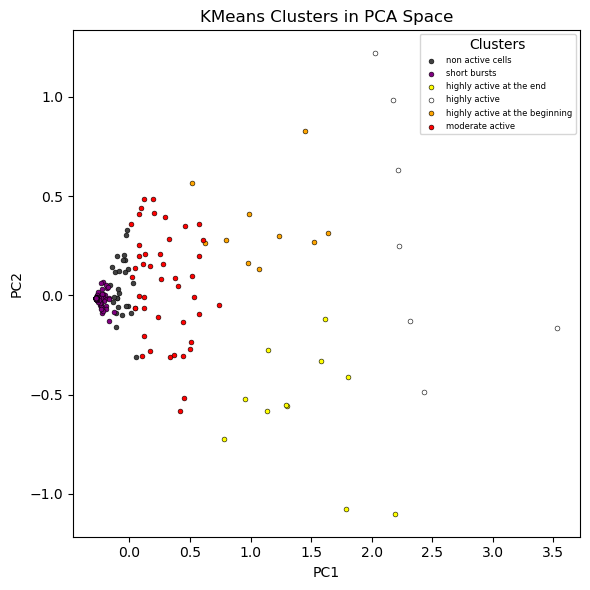

In [209]:
fixed_colors = {
    0: (64/255, 64/255, 64/255),   # dark gray
    1: (1.0, 1.0, 1.0),            # white
    2: (1.0, 1.0, 0.0),            # yellow
    3: (1.0, 0.0, 0.0),            # red
}

plt.figure(figsize=(6,6))
for cid in sorted(cluster_labels.keys()):
    mask = labels == cid
    if not np.any(mask):
        continue
    # Use edgecolor for visibility (especially white)
    plt.scatter(
        Z[mask, 0],
        Z[mask, 1],
        s=12,
        c=[cluster_colors_rgb.get(cid, (0.5,0.5,0.5))],
        label=cluster_labels[cid],
        edgecolors='black',
        linewidths=0.4
    )

plt.title("KMeans Clusters in PCA Space")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title="Clusters", fontsize=6)
plt.tight_layout()
plt.show()

#### Time series clustering

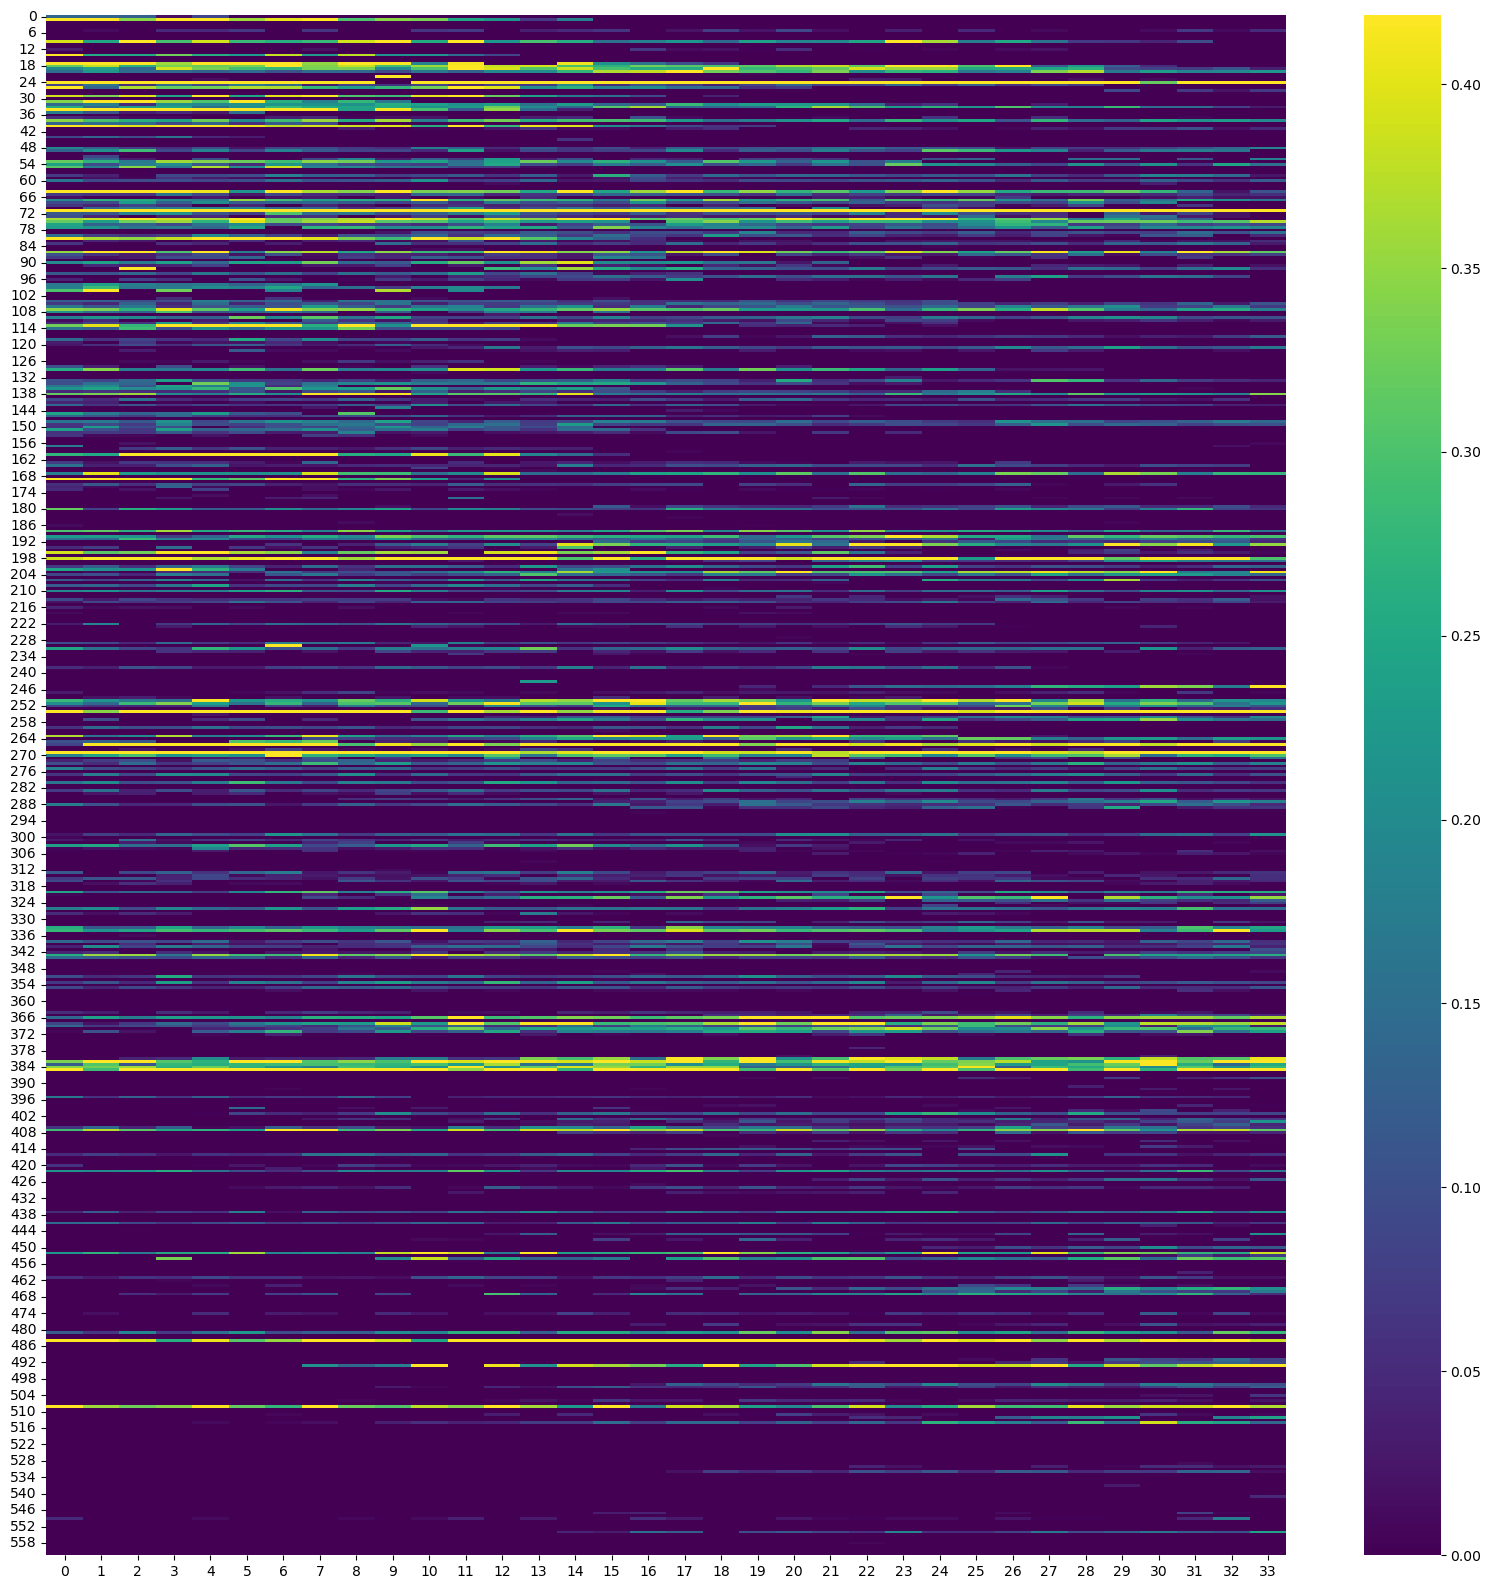

In [279]:
fig = plt.figure(figsize=(20,20))
sns.heatmap(normalized_array, cmap="viridis", robust=True)
plt.show()

In [280]:
def longest_section(x, value=0):
    """
    Find the longest contiguous run in a 1D array where value != 1.
    Returns (length:int, center:float). If no such run, returns (0, None).
    """
    x = np.asarray(x)
    if x.ndim != 1:
        raise ValueError("Input must be 1-D")

    mask = (x != value)
    if not mask.any():
        return 0, len(x) / 2.0

    # Find start/end of True runs in mask
    padded = np.concatenate(([False], mask, [False]))
    changes = np.diff(padded.astype(np.int8))
    starts = np.where(changes == 1)[0]
    ends = np.where(changes == -1)[0]  # position after the last True
    lengths = ends - starts

    i = int(np.argmax(lengths))  # tie-breaker: first longest run
    length = int(lengths[i])
    start = int(starts[i])
    # end_idx = int(ends[i] - 1)  # last index in the run (unused but available)
    center = start + (length - 1) / 2.0  # float center (e.g., 9.5 for even length)

    return length, center

In [281]:
def longest_section_gap_bridge(x, value=0, max_gap=1):
    """
    Find the longest contiguous run in a 1D array where x != value.
    Optionally bridge up to `max_gap` consecutive `value` samples if they are
    strictly surrounded on both sides by samples > value (elongates the run).

    Returns (length:int, center:float). If no run exists, returns (0, len(x)/2).
    """
    x = np.asarray(x)
    if x.ndim != 1:
        raise ValueError("Input must be 1-D")

    n = x.size
    if n == 0:
        return 0, 0.0

    # Base mask: allowed where x != value
    m = (x != value)

    # Bridge small gaps of `value` if bracketed by > value on both sides
    if max_gap > 0 and n >= 3:
        gaps = ~m
        padded = np.concatenate(([False], gaps, [False]))
        changes = np.diff(padded.astype(np.int8))
        startsF = np.where(changes == 1)[0]  # start of False-run (value region)
        endsF   = np.where(changes == -1)[0]  # end index after the run

        for s, e in zip(startsF, endsF):
            L = e - s
            # Only bridge internal gaps (not touching edges) up to max_gap
            if 0 < s and e < n and L <= max_gap:
                if (x[s-1] > value) and (x[e] > value):
                    m[s:e] = True  # bridge (treat as part of the run)

    if not m.any():
        return 0, n / 2.0

    # Longest True-run in m
    padded_m = np.concatenate(([False], m, [False]))
    changes_m = np.diff(padded_m.astype(np.int8))
    startsT = np.where(changes_m == 1)[0]
    endsT   = np.where(changes_m == -1)[0]
    lengths = endsT - startsT

    i = int(np.argmax(lengths))
    length = int(lengths[i])
    start = int(startsT[i])
    center = start + (length - 1) / 2.0

    return length, center


In [282]:
def apply_longest_section(X: np.ndarray, value=1):
    """
    Apply longest_section row-wise on a 2D matrix X (rows are 1D signals).
    Returns an (N, 2) float array: [length, center] per row.
    If no section exists, center is NaN and length is 0.
    """
    X = np.asarray(X)
    if X.ndim != 2:
        raise ValueError("X must be 2-D (rows are signals)")
    out = np.empty((X.shape[0], 2), dtype=float)
    for i in range(X.shape[0]):
        length, center = longest_section(X[i], value=value)
        out[i, 0] = float(length)
        out[i, 1] = np.nan if center is None else float(center)
    return out

In [283]:
results = apply_longest_section(normalized_array, value=0)
log_results = np.log(results + 1e-6)  # avoid log(0)

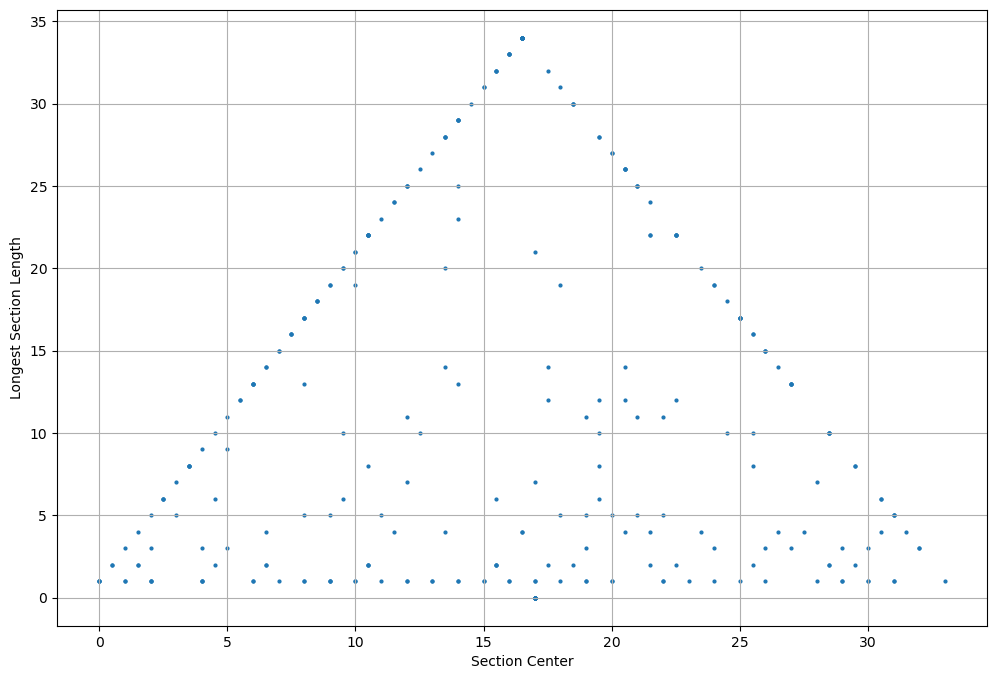

In [284]:
fig, ax = plt.subplots(1, 1,figsize=(12, 8))
ax.scatter(results[:,1], results[:,0], s=4)
ax.set_ylabel("Longest Section Length")
ax.set_xlabel("Section Center")
ax.grid(True)

# ax[1].scatter(log_results[:,0], log_results[:,1], s=4)
# ax[1].set_xlabel("Longest Section Length (log scale)")
# ax[1].set_ylabel("Section Center (log scale)")
# ax[1].grid(True)
# plt.tight_layout()
# plt.show()

In [285]:
def heuristic_activity_clustering(x, timepoints=80, active_threshold=10):
    labels = np.full(x.shape[0], -1, dtype=int)  # -1 means unassigned
    # Cluster 0: non active cells (length == 0)
    labels[x[:,0] == 0] = 0
    # Cluster 1: burst
    mask1 = (x[:,0] == 1)
    labels[mask1] = 1
    # cluster 2: short burst 
    mask2 = (x[:,0] > 1) &  (x[:,0] <=active_threshold)
    labels[mask2] = 2
    # cluster 4: moderate active and late active
    mask4 = (x[:,0] > active_threshold) &  (x[:,0] <=7*active_threshold) & (x[:,1] >= timepoints/2)
    labels[mask4] = 3
    # cluster 5 moderate active and early active
    mask5 = (x[:,0] > active_threshold) &  (x[:,0] <=7*active_threshold) & (x[:,1] < timepoints/2)
    labels[mask5] = 4
    # cluster 6 highly active
    mask6 = (x[:,0] > 7*active_threshold)
    labels[mask6] = 5
    if np.any(labels == -1):
        print(f"Warning: {np.sum(labels == -1)} cells were not assigned to any cluster")
        labels[labels == -1] = 0  # assign unassigned to cluster 0
    return labels

In [295]:
heuristic_labels = heuristic_activity_clustering(results, timepoints=ms2_channel_z_projection.shape[0], active_threshold=2)

In [296]:
heuristic_labels

array([4, 5, 0, 0, 0, 3, 0, 0, 0, 5, 1, 0, 3, 0, 4, 0, 0, 4, 5, 5, 5, 1,
       1, 2, 5, 5, 5, 3, 0, 5, 0, 4, 5, 5, 5, 4, 0, 4, 5, 4, 5, 3, 0, 0,
       4, 1, 0, 0, 5, 5, 0, 1, 4, 5, 5, 4, 0, 0, 5, 4, 5, 1, 0, 0, 5, 5,
       3, 5, 5, 3, 5, 5, 5, 5, 5, 5, 5, 5, 0, 5, 5, 5, 4, 5, 1, 2, 5, 5,
       5, 0, 5, 4, 5, 0, 5, 3, 4, 0, 4, 4, 2, 0, 0, 2, 5, 5, 5, 5, 4, 1,
       5, 3, 5, 5, 4, 0, 0, 5, 4, 4, 4, 5, 4, 0, 0, 0, 4, 0, 4, 5, 1, 0,
       1, 5, 5, 4, 5, 5, 5, 0, 5, 2, 5, 1, 2, 4, 5, 0, 5, 5, 4, 5, 4, 4,
       0, 0, 1, 1, 4, 1, 5, 0, 0, 4, 5, 1, 2, 5, 0, 4, 0, 5, 4, 3, 0, 1,
       2, 0, 0, 5, 5, 0, 1, 1, 0, 1, 1, 0, 5, 0, 5, 5, 3, 5, 3, 2, 3, 0,
       5, 3, 0, 5, 4, 5, 5, 0, 5, 1, 5, 1, 5, 0, 3, 5, 5, 0, 4, 0, 3, 0,
       0, 0, 5, 2, 0, 0, 0, 1, 0, 5, 2, 5, 4, 2, 0, 0, 0, 0, 5, 0, 0, 0,
       0, 1, 0, 5, 1, 3, 0, 4, 5, 5, 5, 3, 5, 1, 5, 3, 0, 0, 5, 1, 0, 5,
       5, 3, 5, 0, 4, 5, 5, 2, 5, 5, 0, 5, 0, 5, 1, 0, 5, 0, 0, 5, 4, 0,
       4, 5, 5, 3, 0, 1, 0, 0, 0, 0, 0, 0, 0, 5, 1,

C:\Users\97254\AppData\Local\Temp\ipykernel_45624\752601277.py:39: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


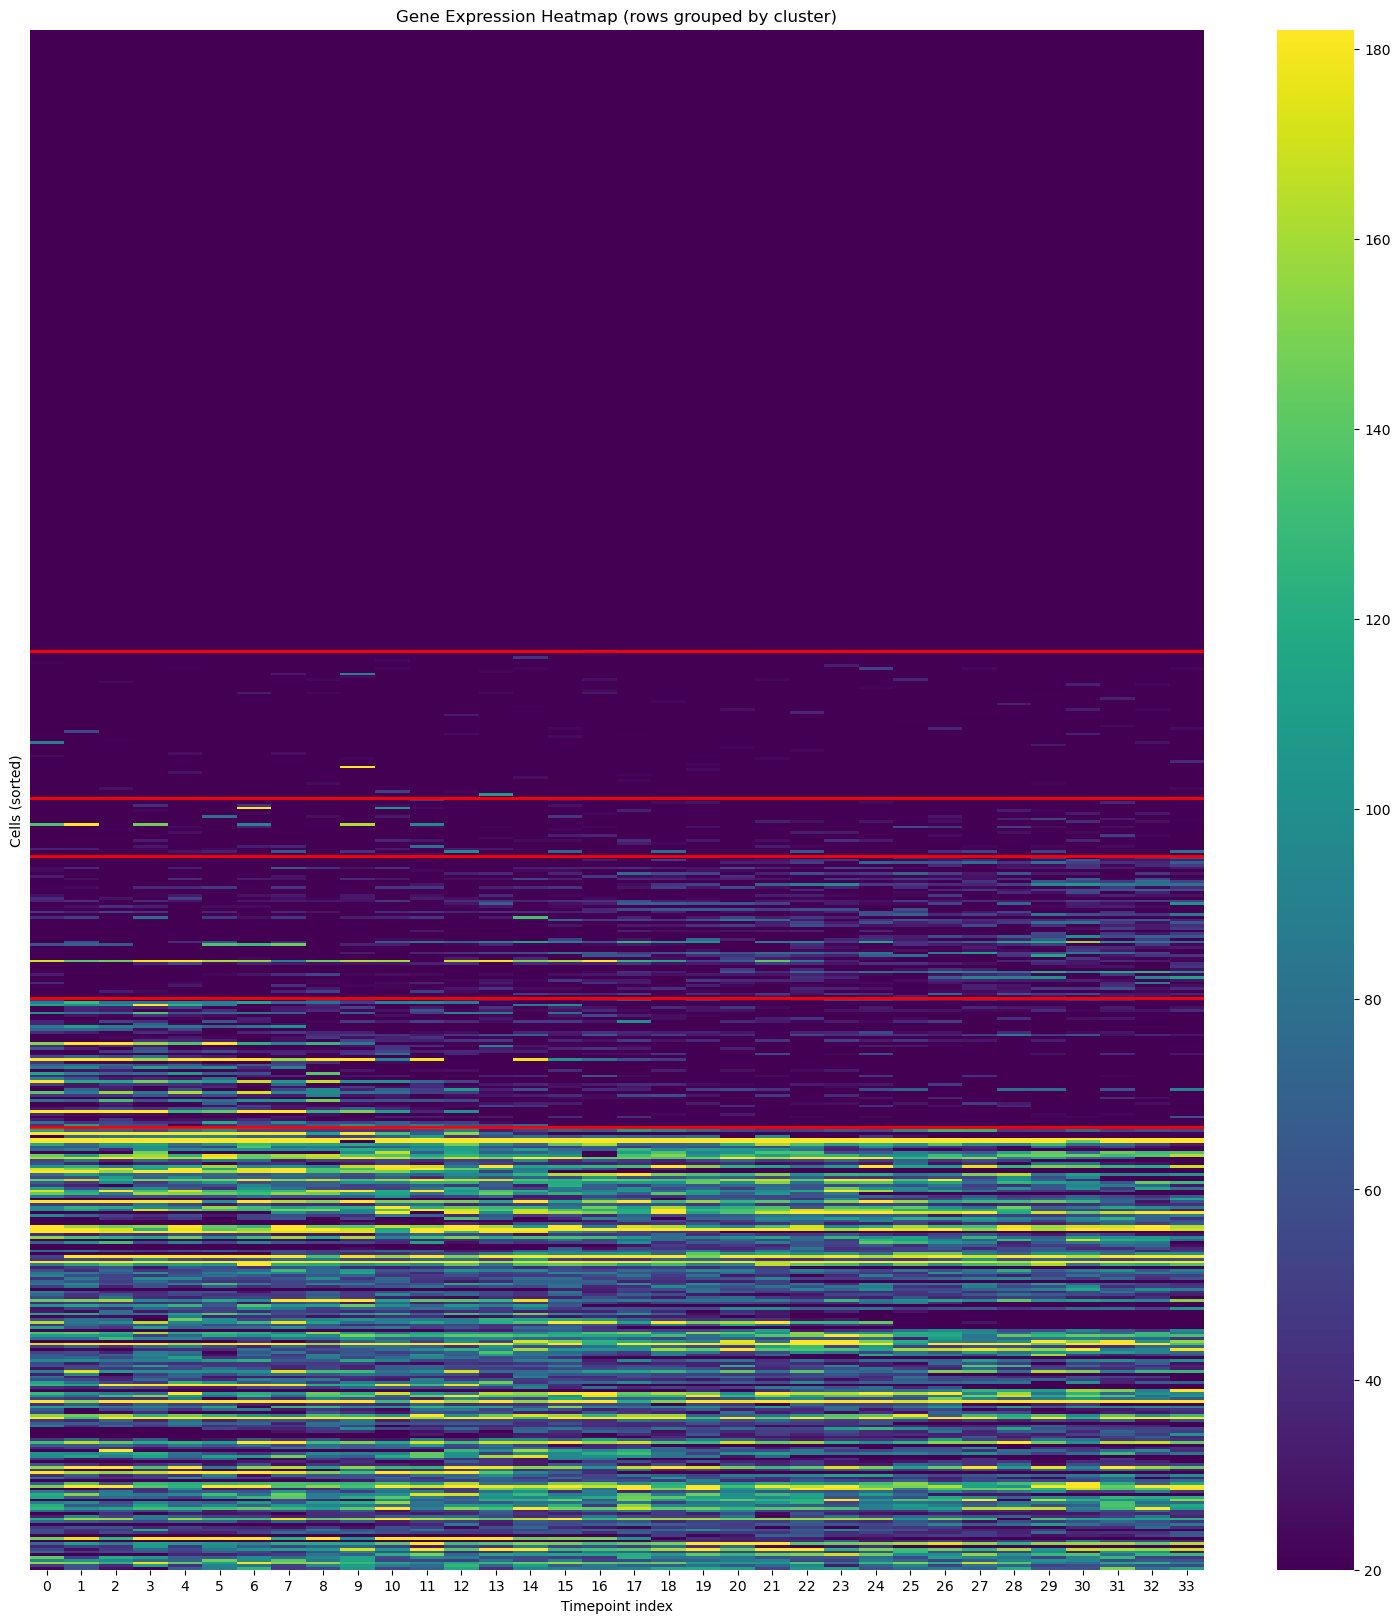

In [297]:
df_time_series = show_clustered_heat_map(heuristic_labels, cells_array, cell_names)

In [220]:
df_time_series_filtered = df_time_series[(df_time_series['cluster'] != 0) & (df_time_series['cluster'] != 1)]

In [221]:
len(df_time_series_filtered), len(df_time_series)

(134, 305)

In [225]:
figures = []
for timepoint in range(ms2_channel_z_projection.shape[0]):
    enhanced_img = enhance_cell_image_contrast(cells_z_project[timepoint])
    masks_t = np.load(masks_paths[timepoint])['masks']
    overlay_img, cluster_colors, cluster_labels = cluster_mask_overlay(
        masks=masks_t,
        clustered_cells_df=df_time_series,
        tracklets=tracklets,
        timepoint=timepoint,
        rng_seed=42,
        base_image=None,
        overlay_alpha=0.6,
        background_color=(0, 0, 0),
        out_dtype=np.uint8,
        cluster_name_map={
            0: "non active cells",
            1: "single bursts",
            2: "short bursts",
            3: "moderate active first half",
            4: "moderate active second half",
            5: "highly active",
        },
        fixed_colors={
            0: (64, 64, 64),      # dark gray
            1: (128,0,128),   # purple
            2: (255, 0, 0),       # purple
            3: (255, 165, 0),     # red
            4: (255, 255, 0),     # yellow
            5: (255, 255, 255),     # white
        })
    fig = plt.figure(figsize=(6,6))
    plt.imshow(overlay_img)
    plt.axis('off')
    plt.title(f"Cluster at timepoint {timepoint}")
    # Legend
    #handles = [Patch(color=np.array(c), label=f"{cluster_labels[cid]}") for cid, c in cluster_colors.items()]
    def _to_rgb01(c):
        c = np.asarray(c, dtype=float).ravel()
        if c.max() > 1.0:
            c = c / 255.0
        return tuple(np.clip(c, 0.0, 1.0))
    handles = [
        Patch(facecolor=_to_rgb01(c), edgecolor='black',
          label=f"{cluster_labels[cid]}")
    for cid, c in cluster_colors.items()]
    plt.legend(handles=handles, loc='upper right', fontsize=6)
    plt.tight_layout()
    figures.append(fig)
    plt.close(fig)
# Save as GIF
create_gif_from_figures(figures[:-1],'mask_overlay_time_series_heuristic_cluster_gRNA2_12.03.25-st-13-II.gif', fps=1)

Saved animation to mask_overlay_time_series_heuristic_cluster_gRNA2_12.03.25-st-13-II.gif


In [ ]:
labels_log_time_series = KMeans(n_clusters=5, random_state=0).fit_predict(log_results)

In [ ]:
pos_active_cells_log = np.where(labels_log_time_series == 4)[0]
pos_active_cells_log

In [ ]:
labels_secondary_time_series_log = KMeans(n_clusters=2, random_state=0).fit_predict(log_results[pos_active_cells_log])
labels_secondary_time_series_log

In [ ]:
pos1 = np.where(labels_secondary_time_series_log == 1)[0]
change_label_pos = pos_active_cells_log[pos1]

In [ ]:
labels_log_time_series[change_label_pos] += 1  # Change to cluster 0

In [ ]:
df_log_time_series = show_clustered_heat_map(labels_log_time_series, cells_array,cell_names)

In [ ]:
figures = []
for timepoint in range(80):
    enhanced_img = enhance_cell_image_contrast(cells_z_project[timepoint])
    masks_t = np.load(masks_paths[timepoint])['masks']
    overlay_img, cluster_colors, cluster_labels = cluster_mask_overlay(
        masks=masks_t,
        clustered_cells_df=df_log_time_series,
        tracklets=tracklets,
        timepoint=timepoint,
        rng_seed=42,
        base_image=None,
        overlay_alpha=0.6,
        background_color=(0, 0, 0),
        out_dtype=np.uint8,
        cluster_name_map={
            0: "short bursts",
            1: "non active",
            2: "non active",
            3: "single bursts",
            4: "highly active",
            5: "moderate active"
        },fixed_colors={
            0: (255,165,0),      # green
            1: (64,64,64),       # red
            2: (64,64,64),   # blue
            3: (255,0,0),     # dark gray
            4: (255, 255, 255),     # white
            5: (255,255,0)     # yellow
        })
    fig = plt.figure(figsize=(6,6))
    plt.imshow(overlay_img)
    plt.axis('off')
    plt.title(f"Cluster at timepoint {timepoint}")
    # Legend
    #handles = [Patch(color=np.array(c), label=f"{cluster_labels[cid]}") for cid, c in cluster_colors.items()]
    def _to_rgb01(c):
        c = np.asarray(c, dtype=float).ravel()
        if c.max() > 1.0:
            c = c / 255.0
        return tuple(np.clip(c, 0.0, 1.0))
    handles = [
        Patch(facecolor=_to_rgb01(c), edgecolor='black',
          label=f"{cluster_labels[cid]}")
    for cid, c in cluster_colors.items()]
    plt.legend(handles=handles, loc='upper right', fontsize=6)
    plt.tight_layout()
    figures.append(fig)
    plt.close(fig)
# Save as GIF
create_gif_from_figures(figures[:-1],'mask_overlay_time_series_cluster_log.gif', fps=1)